# Supervised Learning Using DeepChem

This is the last notebook to do as part of this course (reinforcement learning, which is the missing third of ML is currently used less for ML, but keep an eye out for it being used more in retrosynthesis in the future). 

At this point, I thought I would give you some resources to continue learning from: 

*Paid*

1. O'Reilly, 'Hands on machine learning with scikit-learn and tensorflow (2nd edition), Aurelien Geron
https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/
If you were to buy one ML textbook I would get this one. It's about £40. Make sure you get the 2nd edition as that includes tensorflow2 which is the newer (and ever so much easier to use) version of tensorflow. The code used in the textbook is here: https://github.com/ageron/handson-ml2

2. O-Reilly, /'Deep learning for the life sciences'/
https://www.oreilly.com/library/view/deep-learning-for/9781492039822/
This is OK, it has some nice deepchem examples, however, the book is rather short and half of it is biology related, so this is best a book that is borrowed from the library

*Free*

1. DeepChem's tutorials: 
https://github.com/deepchem/deepchem/tree/master/examples
Download or pull these and run them in the environment set up for these notebooks. They will introduce you to deepchem and covers more material than this course was able to 

2. Deep Learning for hte life sciences example code
https://github.com/deepchem/DeepLearningLifeSciences
The code from the book above. Useful to look at if you're not able to borrow the book. 

You do not need to buy any books if you don't want to!

### DeepChem

You will be using several different modules here

**DeepChem** [1,2] is a lovely module that has only recently appeared, and it will make using ML for chemistry so much easier! In this section we shall play with it and try to solve some chemical problems.


**MoleculeNet** [3,4] is a series of _benchmark_ datasets for chemistry, these are standard datasets that people can use to test their algorithms against. Also, they are problems worth solving in their own right. 

**Tensorflow** [5] is a ML package that we met in the previous workbook, it is powerful and useful, however writing tensorflow code directly is fiddly (as least I think so!)

**Keras** [6] is a module for writing, training and testing ML/neural networks (NN), it will write the correct tensorflow code for you. 

DeepChem contains both keras and tensorflow, so you can use those modules from within it. 

rdkit is a general purpose computational chemistry module which we will use for plotting molecules, but you can also use it to calculate molecular properties.

[1] https://deepchem.io/

[2] https://github.com/deepchem

[3] Wu, Zhenqin, et al. "MoleculeNet: a benchmark for molecular machine learning." Chemical science 9.2 (2018): 513-530.

[4] https://deepchem.readthedocs.io/en/latest/moleculenet.html

[5] https://keras.io/
[6] https://www.tensorflow.org/

In [3]:
!conda install -c conda-forge scikit-learn

Solving environment: done

# All requested packages already installed.



In [1]:
# lets load our libraries
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf

/home/ella/anaconda3/envs/ml-for-chemists-tf1/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/ella/anaconda3/envs/ml-for-chemists-tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ella/anaconda3/envs/ml-for-chemists-tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated;

## Supervised Learning

Supervised learning is when the algorithm is given the answer (target) to learn from. Essentially, the algorithm is given in the input data, it guesses a solution to get a prediction (output), and this is compared to the correct answer. Obviously the first guess is wrong, but by comparing the prediction ($\hat{\textbf{y}}$) to the true answer, *target* or *ground truth* (**y**) the model can *learn* and improve its predictions.

Supervised learning models *fit* a *function* from *features* (**X**) to *target(s)* (**y**). For example, the features may be a set of *fingerprints* (created from a chemical structure) and the target may be a molecular property, like atomic energy, solubility, or action against a protein target.

There are many supervised learning algorithms, but most the recent breakthroughs in ML have come from **neural networks** and this is what we will concentrate on here. This notebook contains chemical models, see 4_Supervised_Learning for neural networks applied to standard NN problems (vision) to help you understand how NNs work.

## Types of problems: 

#### Regression

The regression discussed here is exactly the same as that in notebooks 1 and 2a, however as the input data is highly multidimentional (often 1000's of dimensions), the fitted function is a multi-dimensional object, for this reason we do not plot the fitted function (as we did in the Linear_Regression_Cellulose notebook). Instead, we are interested in how well the model *predicts* the training set data, and *generalises* to the test data. 

Regression models can be thought of as fitting a function:
$$
\textbf{X} \rightarrow Model \rightarrow \textbf{y}
$$

where **y** is usually a number. 

#### Classificiation

Classification models assign input data to a *category*. For example, matching a molecular structure to the category 'active against HIV protein'. See notebook 4 for more examples. 

#### Generation

Generative models produce new examples of the input after training. For example, you might train a variational autoencoder on molecular structures and then use it to generate novel molecular structures. 

In this document we shall train some regression and classification models.

## Datasets

When training an ML algorithm, it is common practice to split your data into 2 or 3 datasets:

1. Train: this is the majority of the data, and it is used to train the ML algorithm. 
2. Test: this is data that is NEVER shown to the algorithm during training and only used at the end to test the algorithm.
3. Validation: this is data that is not used for training but is used to test the algorithm during training (validate the algorithm). 

The point of building supervised ML algorithms is not generally to describe your data, but to use the model in the future to predict **y** for new data. For example, in the IMPRESSION NMR prediction program [[]] input molecular structure is mapped to output chemical shifts. This is not used to model what the NMR is for the molecules in the dataset (as we already know that, we used it to train the algorithm in the first place!), but to predict the chemical shifts for an unseen molecule, for example, one that a synthetic chemist has just made.

The test set is held out and not used for training to get an idea how an algorithm will work on as-yet-unseens data. N.B. This is the equivalent of the leave-one-out approach used in design of experiments and regression models, only here instead of leaving a single datapoint out of a small dataset, we leave a fraction (usually 10%) out. 

As ML algorithms have such a large degree of power to fit data, they have the problem of *over-fitting*, where the algorithm learns to memorise the dataset, and this makes the algorithm less useful for generalisation. So, we use the validation dataset as a practise test set. The algorithm is tested on this dataset after every epoch of training, and overfitting happens once the validation set stops improving. 

Common splits for the data are:
Train: 90% : Test: 10% 
or Train: 80%, Validation: 10%, Test: 10%

## Delaney Dataset for drug solubility

The Delaney (ESOL) dataset [7] a regression dataset containing structures and water solubility data for 1128 compounds. The dataset is widely used to validate machine learning models on estimating solubility directly from molecular structures (as encoded in SMILES strings). Solubility is vital to achieve desired concentration of drug for anticipated pharmacological response. 

[7] Delaney, J. S. *Journal of Chemical Information and Modeling*, **44**, 1000–1005 (2004)

DeepChem has methods to load datasets:

In [2]:
# this line loads the Delaney dataset
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP')
# the datasets object is already split into the train, validation and test dataset 
train_dataset, valid_dataset, test_dataset = datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/delaney-processed.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 1.254 s
TIMING: dataset construction took 1.295 s
Loading dataset from disk.
TIMING: dataset construction took 0.044 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.031 s
Loading dataset from disk.
TIMING: dataset construction took 0.006 s
Loading dataset from disk.
TIMING: dataset construction took 0.006 s
Loading dataset from disk.


Here is some example data from the test set. There are 1049 features generated from the SMILES strings (scroll right to see the SMILES). 

In [3]:
test_dataset.to_dataframe().head()

AttributeError: 'DiskDataset' object has no attribute 'to_dataframe'

#### Featurizing inputs

To build a NN that can categorize images (i.e. map a picture of a cat to 'cat') you use images at inputs.

It is not immediately obvious to know how best to input molecular structure. SMILES strings are designed to computer readable formulae, these can be convereted to test inputs (strings). There are several ways to extract the information from molecular structure, and this is called featurizing the molecule. 

Some examples:

*SMILES strings*: 'Cc1cc(=O)[nH]c(=S)[nH]1'

*Molecular descriptors*: a list of physicochemical properties about the molecule, for example: molecular weight, boiling point, dipole moment etc (these were used in notebook 2 and called `solvent parameters`).

*Molecular graphs*: the chemical formula (as you would draw by hand)

*Extended Connectiviy FingerPrints (ECFP)*: this is a vector of 1s and 0s that indicates the presence of absence of features like atoms, functional groups, number of covalent bonds etc. This is the featurization that we're using here.

*voxels*: a voxel is a 3-D pixel, i.e. a cube of space. This featurisation encodes 3D structural data by indicating hte presence or absence of an atom in that cube of space.

 The code below tells you about the dataset. 
 `X` (the input) has 113 rows (corresponding to 113 molecules) and 1024 columns corresponding to 1024 features, with `ids` (identification) which are SMILEs strings,
 and `task_names` which is the name of the target, in this case, the `measured log solubility in mols per litre` for the molecule.

In [4]:
print(test_dataset)

### Looking at the molecules

To display a molecular graph (or chemical formula, as you know it) we use `rdkit`'s `Chem` module imported above to read SMILEs strings: 

Look, a molecule!

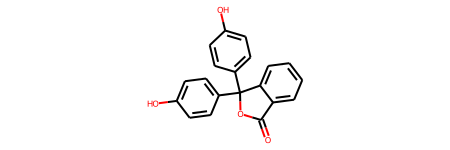

In [5]:
molecule='Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 '
Chem.MolFromSmiles(molecule)

## Random Forest Regression

A *decision tree* is a simple ML algorithm which is basically a flow chart of yes/no questions. For example:


`-OH present?
    yes -->
        C=0 present?
            yes --> carboxylic acid
            no --> alcohol
    no --> etc `

A *random forest* is a collection (a forest in fact) of decision trees. see:
https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Random forests are simple ML algorithms, and as such they are easy to tune and are a good algorithm to start with. They are often then used as a benchmark (to beat) for more complicated algorithms.

In [6]:
# this loads in the method used to create the RandomForestRegerssor model
from sklearn.ensemble import RandomForestRegressor

# This line creates a new Random forest regressor object, which we give the name: RF_model
# this is an Sklearn model
RF_model = RandomForestRegressor(n_estimators=100)
# This line tells deepchem that RF_model is a SKleanr model and gives it a new name: model
model = dc.models.SklearnModel(RF_model)
############################################
# Now we fit the training dataset!             #
############################################
model.fit(train_dataset)

To find out how well our model performs, we use what is called a *metric*. The word metric basically means a ruler, and we use it to measure the model. 

For regression models, the most commonly used metric is the R$^2$ score (technically called the Pearson R$^2$ score). This is the R$^2$ we met in the linear regression workbook. 

A high R$^2$ on the training dataset tells us that the model is learning well. 
A high R$^2$ on the test dataset tells us that we have a good model for generalisation, i.e. one that is useful!

Note that the `transformer` is the method we used to put the data in the correct format (we got that from the dataset above).

In [7]:
# this line tells deepchem what metric to use to score the datasets
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

# model.evaluate() tests the model. 
# we have to give it the data to use, the metric (or set of metrics) and the transformer used

print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

computed_metrics: [0.9516246378795497]
Training set score: {'pearson_r2_score': 0.9516246378795497}
computed_metrics: [0.6805611900346754]
Test set score: {'pearson_r2_score': 0.6805611900346754}


As you can see, the random forest trains well on the data, but does not make a good predictive model.

Let's see what those predictions are:

In [8]:
# this line picks a batch of 12 molecules and gets the predicted solubilities
solubilities = model.predict_on_batch(test_dataset.X[:12])
# this grabs the first 12 smiles strings as well
SMILES_strings = test_dataset.ids[:12]
# this line picks a batch of 12 molecules and gets the predicted solubilities
ground_truth = test_dataset.y[:12]
# this makes an empty list called mol_list
mol_list=[]
print('\tSolubility\t\tMolecule')
print('Predicted\tActual\t\t\n')
# this loops over the numbers 0 to 11 ...
for i in range(12):
    print("{:.3}\t\t{:.3}\t\t{}".format(solubilities[i], ground_truth[i][0], SMILES_strings[i]))

	Solubility		Molecule
Predicted	Actual		

-1.16		-1.71		C1c2ccccc2c3ccc4ccccc4c13
-0.0844		0.291		COc1ccccc1Cl
-1.15		-1.43		COP(=S)(OC)Oc1cc(Cl)c(Br)cc1Cl
-0.591		-0.925		ClC(Cl)CC(=O)NC2=C(Cl)C(=O)c1ccccc1C2=O
-1.57		-1.95		ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2 
1.27		1.35		COC(=O)C=C
-0.113		-0.859		CN(C)C(=O)Nc2ccc(Oc1ccc(Cl)cc1)cc2
0.368		-0.651		N(=Nc1ccccc1)c2ccccc2
-0.488		-0.329		CC(C)c1ccc(C)cc1
0.2		0.608		Oc1c(Cl)cccc1Cl
1.18		1.83		OCC2OC(OC1(CO)OC(CO)C(O)C1O)C(O)C(O)C2O 
1.23		1.62		OC1C(O)C(O)C(O)C(O)C1O


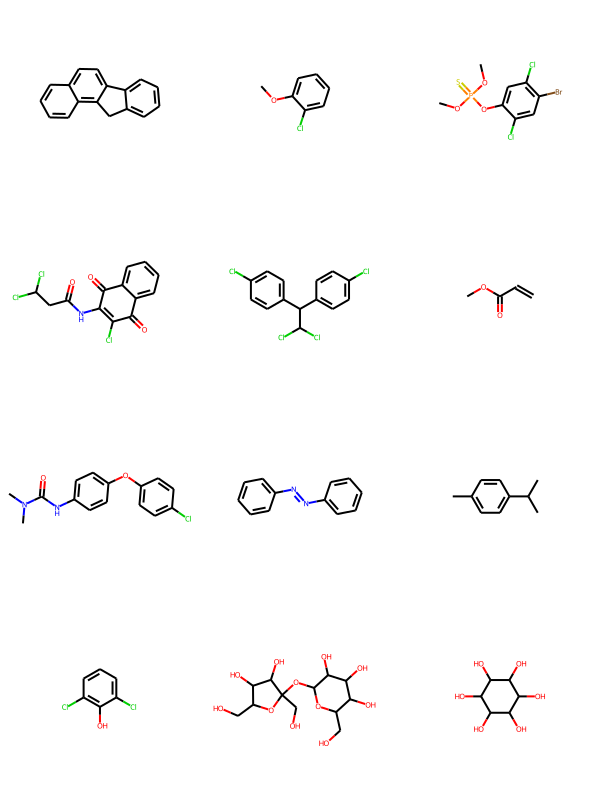

In [9]:
# and this draws a nice image of the 12 molecules
ms = [Chem.MolFromSmiles(x) for x in SMILES_strings]
Draw.MolsToGridImage(ms)

## Graph convolution networks

So the random forest wasn't that great a predictive model, can we do better?

Neural networks are very powerful supervised learning algorithms, and we're going to use one specialised for molecular graphs (like those shown above). 

to do this we reload the Delaney dataset, this time using the graph convolution featurizer.

In [10]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/delaney-processed.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 0.973 s
TIMING: dataset construction took 1.155 s
Loading dataset from disk.
TIMING: dataset construction took 0.187 s
Loading dataset from disk.
TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.218 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


This is the code to make a graph convolution model. 

`Dropout` is a technique to avoide over-fitting, it randomly disconnects some of the neurons in the neural network forcing the algorithm to involve many neurons in the task.

In [11]:
# we build a graph convolutional model and call it model
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [12]:
# train it
model.fit(train_dataset, nb_epoch=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ella/anaconda3/envs/ml-for-chemists-tf1/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ella/anaconda3/envs/ml-for-chemists-tf1/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ella/anaconda3/envs/ml-for-chemists-tf1/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.0

In [13]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

computed_metrics: [0.9500765952035981]
Training set score: {'pearson_r2_score': 0.9500765952035981}
computed_metrics: [0.8442636022496075]
Test set score: {'pearson_r2_score': 0.8442636022496075}


And here we can look at the results for that batch of 12 examples from the test dataset

In [14]:
# this line picks a batch of 12 molecules and gets the predicted solubilities
solubilities = model.predict_on_batch(test_dataset.X[:12])
# this grabs the first 12 smiles strings as well
SMILES_strings = test_dataset.ids[:12]
# this line picks a batch of 12 molecules and gets the predicted solubilities
ground_truth = test_dataset.y[:12]
# this makes an empty list called mol_list
mol_list=[]
print('\tSolubility\t\tMolecule')
print('Predicted\tActual\t\t\n')
# this loops over the numbers 0 to 11 ...
for i in range(12):
    print("{:.3}\t\t{:.3}\t\t{}".format(solubilities[i][0], ground_truth[i][0], SMILES_strings[i]))

	Solubility		Molecule
Predicted	Actual		

-1.21		-1.71		C1c2ccccc2c3ccc4ccccc4c13
0.466		0.291		COc1ccccc1Cl
-1.07		-1.43		COP(=S)(OC)Oc1cc(Cl)c(Br)cc1Cl
-0.329		-0.925		ClC(Cl)CC(=O)NC2=C(Cl)C(=O)c1ccccc1C2=O
-1.57		-1.95		ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2 
1.36		1.35		COC(=O)C=C
-0.483		-0.859		CN(C)C(=O)Nc2ccc(Oc1ccc(Cl)cc1)cc2
0.656		-0.651		N(=Nc1ccccc1)c2ccccc2
-0.394		-0.329		CC(C)c1ccc(C)cc1
0.911		0.608		Oc1c(Cl)cccc1Cl
1.15		1.83		OCC2OC(OC1(CO)OC(CO)C(O)C1O)C(O)C(O)C2O 
1.53		1.62		OC1C(O)C(O)C(O)C(O)C1O


As you can see, the neural network model has worked much better at predicting solubility on the test set.

## Making your own models

In this section, we will write our own keras code to create different neural networks and see which is best for solving the delaney dataset.

Have a look at the neural networks powerpoint to find out what these things are. We will make a simple *fully-connected* neural network which takes in the ECFP fingerprints.

### Regression

In [15]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


Below is the neural network. 

`tf.keras.Sequential` is a *wrapper* function that tells keras that we're using a sequential model, i.e. a simple neural network. 

The data in input into the network and then flows into:
`tf.keras.layers.Dense(50, activation='sigmoid')`
this is a standard *fully connected* layer (which keras calls `Dense` as there are many many connections). The first number, `50` tells keras how many units we want in the layer. The `activation function` is a mathematical function whose purpose is to add *non-linearity* to the system. Neural networks can be described as a type of *non-linear regression model*, they are very powerful and part of that power comes from the non-linearity. 

The data flows through the first layer (the one with 50 units) and into the second (and final) layer:
`tf.keras.layers.Dense(1)`
this has only 1 unit and no non-linearity (the default activation is linear). For regression models we read out the number that flows out of this single unit, and that is our prediction!

This is a *tiny* neural network. It has an input layer (not shown as keras assumes you have an input!), a single *hidden layer* (this one: `tf.keras.layers.Dense(50, activation='sigmoid')`) and an *output layer* (this one: `tf.keras.layers.Dense(1)`), so this is a single hidden layer model, a *shallow* network. These were the types of NNs that people used in the 1990s, however, it was then discovered that adding more hidden layers made more powerful NNs. A network with more than one hidden layer is called a *deep neural network*. Now, there are deep NNs with hundreds of layers, usually of many different types. 

In [16]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid'), # hidden layer
    tf.keras.layers.Dense(1) # output layer
])

As before, in deepchem we must wrap our keras_model in a wrapper function `dc.models.KerasModel()` to tell deepchem what it is. The second term in this wrapper function is the `loss function`, this is the function that tells deepchem what to `minimize` to train the model. To train the model, we want to minimize the error between the predicted output $\hat{\mathbf{y}}$ and the ground truth $\mathbf{y}$. There is more than one solution that the NN could find, so we use the loss function to guide it towards a solution we think would be good, we do this by adding in an extra error term which it also has to minimize and which is higher the further the NN is from the type of solution we think would be good. 

In [17]:
# makes a deep chem model from our keras model, and tells it what loss function to use 
model = dc.models.KerasModel(keras_model, dc.models.losses.L1Loss())

 Neural networks require seeing the data more than once to learn. Each time we show it a copy of the training data is an *epoch*. Here we train for 50 epochs, which is 50 presentations of the data. Usually, you set up the training to stop automatically once you reach a good solution. 

In [18]:
# fits the model
model.fit(train_dataset, nb_epoch=50)
# sets R2 as the metric
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
# tests and prints out the model
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.8611471820253771]
training set score: {'pearson_r2_score': 0.8611471820253771}
computed_metrics: [0.5994976761796923]
test set score: {'pearson_r2_score': 0.5994976761796923}


### Task 1: Making a good model to predict drug solubility from structure

Can you improve on the model above? 

The best I've found is an $R^2$ *on the test dataset*  of 0.74. Can you beat it?

##### Things to add:

*types of layers*
1. tf.keras.layers.Dense(1000, activation='relu')
2. tf.keras.layers.Dropout(rate=0.5)
3. tf.keras.layers.BatchNormalization(),

You can change the number of neurons: 

`tf.keras.layers.Dense(*1000*, activation='relu')` --> `tf.keras.layers.Dense(*200*, activation='relu')`

You can change the activation function:

`tf.keras.layers.Dense(1000, activation=*'relu'*)` --> `tf.keras.layers.Dense(1000, activation=*'sigmoid'*)`

You can add in normalisation or dropout layers:

`tf.keras.layers.Dropout(rate=0.5) (and you can change the rate)`
`tf.keras.layers.BatchNormalization()`

These are applied to `Dense` layers so need to come after them, e.g. this model still has only 1 hidden layer, but that layer has dropout applied to it: 

`keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])`

You can change the loss function, here's some to try:

`dc.models.losses.L1Loss()`
`dc.models.losses.L2Loss()`
`dc.models.losses.L1Loss()`
`dc.models.losses.SigmoidCrossEntropy()`
`dc.models.losses.BinaryCrossEntropy()`

Note that each time you train a NN, you get a different solution, so the same model may give better or worse solutions to the problem.

In [19]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L1Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.8730821263696091]
training set score: {'pearson_r2_score': 0.8730821263696091}
computed_metrics: [0.6146797587602841]
test set score: {'pearson_r2_score': 0.6146797587602841}


In [20]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(200, activation='relu'),
    #tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))



computed_metrics: [0.9825735192108754]
training set score: {'pearson_r2_score': 0.9825735192108754}
computed_metrics: [0.7470096680849331]
test set score: {'pearson_r2_score': 0.7470096680849331}


In [21]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.981977969728467]
training set score: {'pearson_r2_score': 0.981977969728467}
computed_metrics: [0.7276061588632968]
test set score: {'pearson_r2_score': 0.7276061588632968}


## Classificiation

In this section, we will classify the input molecules. Here, we are looking for which molecules are active at prevented HIV replication. (Notebook 4 gives further detail on what classification is). 

#### The HIV dataset

"The HIV dataset was introduced by the Drug Therapeutics Program (DTP) AIDS AntiviralScreen,  which  tested  the  ability  to  inhibit  HIV  replication  for  over  40,000  compounds. 47 Screening results were evaluated and placed into three categories:  confirmed inactive (CI), confirmed active (CA) and confirmed moderately active (CM). We further combine the latter  two  labels,  making  it  a  classification  task  between  inactive  (CI)  and  active  (CA  and CM). As we are more interested in discover new categories of HIV inhibitors, scaffold split-ting(introduced in the next subsection) is recommended for this dataset." (Taken from the MoleculeNet paper). 



As before, we download and featurize the dataset.

In [22]:
tasks, datasets, transformers = dc.molnet.load_hiv(feturizer='ECFP', splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/HIV.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 10.171 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 9.996 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 10.252 s
Loading shard 4 of size 8192.
Featurizing sample 0
Featuriz

RDKit WARNING: [16:10:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:10:13] WARNING: not removing hydrogen atom without neighbors


Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 4 took 10.065 s
Loading shard 6 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 5 took 0.222 s
TIMING: dataset construction took 51.733 s
Loading dataset from disk.
TIMING: dataset construction took 1.515 s
Loading dataset from disk.
TIMING: dataset construction took 0.528 s
Loading dataset from disk.
TIMING: dataset construction took 0.537 s
Loading dataset from disk.
TIMING: dataset construction took 1.291 s
Loading dataset from disk.
TIMING: dataset construction took 0.506 s
Loading dataset from disk.
TIMING: dataset construction took 0.520 s
Loading dataset from disk.
TIMING: dataset construction took 1.064 s
Loading dataset from disk.
TIMING: dataset construction took 0.140 s
Loading dataset from disk.
TIMING: dataset construction took 0.147 s
Loading dataset from disk.


We now make a classification model. 

This has 1 output, which will be a binary number (1 or 0) indicating whether the drug molecule is active against HIV (1) or not active (0). This is a very hard problem and one under active research. We're asking the neural network to learn what molecules are, and approximate, from the data, which aspects of the molecule might disrupt a complex process involving a virus and cells. There are many different places in this process where the drug could be acting. Frankly, I'm surprised that this works at all! The fact that it does work is a testiment to how powerful neural networks are. 

We use a different metric here. For the regression model we used $R^2$, in notebook 4, we used *accuracy*, here we use *receiver-operator characteristic* **ROC**. (The term comes from sending signals over the radio), and is a different measure of the accuracy of the model. It compares the predictions it got correct: true positives (those it said were active and are) and true negatives (those it said were inactive which are inactive) with the predictions it got incorrect: false positives (molecules it said were active, but which are not) and false negatives (those it said were inactive, but which work). 

And ROC of 1 is perfect, and ROC of 0.5 is the same as guessing randomly (i.e. not very good at all!).

In [23]:
classification_model = tf.keras.Sequential([
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
])
model = dc.models.KerasModel(classification_model, dc.models.losses.SigmoidCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))



computed_metrics: [0.5]
training set score: {'roc_auc_score': 0.5}
computed_metrics: [0.5]
test set score: {'roc_auc_score': 0.5}


## Task 2: Make a better classification neural network to screen anti-viral drugs for action against HIV

Try modifying the NN below to see if you can improve the ROC score on the test set. 

the best I've managed is 0.70

In [24]:
classification_model = tf.keras.Sequential([
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
])
model = dc.models.KerasModel(classification_model, dc.models.losses.SigmoidCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.5]
training set score: {'roc_auc_score': 0.5}
computed_metrics: [0.5]
test set score: {'roc_auc_score': 0.5}


In [25]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1,activation='softmax'),
])
model = dc.models.KerasModel(classification_model, dc.models.losses.BinaryCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.9999974749825083]
training set score: {'roc_auc_score': 0.9999974749825083}
computed_metrics: [0.6460260008863938]
test set score: {'roc_auc_score': 0.6460260008863938}


In [26]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1,activation='softmax'),
])
model = dc.models.KerasModel(classification_model, dc.models.losses.BinaryCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.99999606567042]
training set score: {'roc_auc_score': 0.99999606567042}
computed_metrics: [0.6651309541396704]
test set score: {'roc_auc_score': 0.6651309541396704}


In [27]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dense(1,activation='softmax'),
])
model = dc.models.KerasModel(classification_model, dc.models.losses.BinaryCrossEntropy())

model.fit(train_dataset, nb_epoch=100)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

computed_metrics: [0.9999883731752712]
training set score: {'roc_auc_score': 0.9999883731752712}
computed_metrics: [0.669934364645548]
test set score: {'roc_auc_score': 0.669934364645548}


## STOP HERE:

this is the end of this notebook. 

Go and do notebook 4 if you haven't!

In [31]:
!conda install -c conda-forge -y pdbfixer

Solving environment: done

## Package Plan ##

  environment location: /home/ella/anaconda3/envs/ml-for-chemists-tf1

  added / updated specs:
    - pdbfixer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cudatoolkit-11.2.1         |       h8204236_8       877.7 MB  conda-forge
    fftw-3.3.9                 |nompi_h74d3f13_100         6.4 MB  conda-forge
    ocl-icd-2.2.14             |       h7f98852_0         118 KB  conda-forge
    ocl-icd-system-1.0.0       |                1           4 KB  conda-forge
    openmm-7.5.0               |   py37h1b3cdbe_6        10.8 MB  conda-forge
    pdbfixer-1.7               |     pyhd3deb0d_0         167 KB  conda-forge
    ------------------------------------------------------------
                                           Total:       895.2 MB

The following NEW packages will be INSTALLED:

  cudatoolkit        conda-forge/linux-64::cudato

In [32]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(featurizer='grid', split='random')
train_dataset, valid_dataset, test_dataset = datasets

Dataset does not exist at /tmp/from-pdbbind/full_protein-core-grid-random. Reconstructing...

Raw dataset:
/tmp/pdbbind/v2015

Featurized and splitted dataset:
/tmp/from-pdbbind/full_protein-core-grid-random

Featurizing Complexes for "/tmp/pdbbind/v2015" ...

TIMING: Loading protein coordinates took 4.871 sTIMING: Loading protein coordinates took 4.926 s

TIMING: Loading protein coordinates took 4.960 s
TIMING: Loading protein coordinates took 5.048 s
TIMING: Loading protein coordinates took 5.023 s
TIMING: Loading protein coordinates took 5.910 s
TIMING: Loading ligand coordinates took 1.959 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 1.971 sTIMING: Loading ligand coordinates took 1.863 s

TIMING: Centroid processing took 0.000 sTIMING: Loading ligand coordinates took 1.975 sTIMING: Centroid processing took 0.000 s


TIMING: Centroid processing took 0.000 sTIMING: Loading ligand coordinates took 2.100 s

TIMING: Centroid processing took 0.000 s


TIMING: Loading protein coordinates took 2.537 s
TIMING: Loading ligand coordinates took 2.171 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 0.249 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 6.297 s
TIMING: Loading protein coordinates took 4.817 s
TIMING: Loading protein coordinates took 4.446 s
TIMING: Loading ligand coordinates took 0.426 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 15.543 s
TIMING: Loading ligand coordinates took 0.494 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 2.017 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 3.774 s
TIMING: Loading ligand coordinates took 2.209 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 0.179 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 5.376 s
TIMING: Loading ligand coordinate

TIMING: Loading ligand coordinates took 2.011 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 10.322 s
TIMING: Loading ligand coordinates took 0.139 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 9.477 s
TIMING: Loading ligand coordinates took 0.362 s
TIMING: Centroid processing took 0.003 s
TIMING: Loading protein coordinates took 5.606 s
TIMING: Loading ligand coordinates took 0.539 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 4.217 s
TIMING: Loading ligand coordinates took 0.135 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 96.114 s
TIMING: Loading ligand coordinates took 0.436 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 7.430 s
TIMING: Loading ligand coordinates took 0.126 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 6.064 s
TIMING: Loading protein coordina

TIMING: Loading ligand coordinates took 2.105 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 39.005 s
TIMING: Loading protein coordinates took 8.245 s
TIMING: Loading ligand coordinates took 0.435 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 0.141 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 5.371 s
TIMING: Loading protein coordinates took 4.777 s
TIMING: Loading ligand coordinates took 0.257 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 0.427 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordinates took 13.783 s
TIMING: Loading protein coordinates took 8.328 s
TIMING: Loading protein coordinates took 6.111 s
TIMING: Loading ligand coordinates took 1.772 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading ligand coordinates took 1.960 s
TIMING: Centroid processing took 0.000 s
TIMING: Loading protein coordina

In [35]:
n_features=train_dataset.X.shape[1]
model = dc.models.MultitaskRegressor(
    n_tasks=len(tasks),
    n_features=n_features,
    layer_sizes=[2000,1000],
    dropouts=0.5,
    learning_rate=0.0003)
model.fit(train_dataset, nb_epoch=250)

0.0

## Splitting datasets to ensure a fair test

splitters = ['random', 'scaffold', 'butina']

In [37]:
split_method = 'butina'
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', split=split_method)
train_dataset, valid_dataset, test_dataset = datasets
model = dc.models.MultitaskClassifier(n_tasks=len(tasks), n_features=1024, layer_sizes=[1000])
model.fit(train_dataset, nb_epoch=10)
print('splitter:', splitter)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))
print()

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0


RDKit WARNING: [16:51:25] WARNING: not removing hydrogen atom without neighbors


Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 9.297 s
TIMING: dataset construction took 9.500 s
Loading dataset from disk.
Performing butina clustering with cutoff of 0.18


RDKit WARNING: [16:51:35] WARNING: not removing hydrogen atom without neighbors


# of actives per task in valid: [ 4.  1.  2. 23. 29. 14.  1. 32.  5. 11. 34.  2.]
Total # of validation points: 286
TIMING: dataset construction took 0.264 s
Loading dataset from disk.
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.001 s
Loading dataset from disk.
TIMING: dataset construction took 0.245 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


UnboundLocalError: local variable 'X_shape' referenced before assignment

#### Task: try out the other options for splitting the dataset, which splitting method do you think is the best and why?

You may want to run this a few times and think about what the splits mean, do you trust all of the answers?

In [ ]:
splitters = ['random', 'scaffold', 'butina']
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for splitter in splitters:
    tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', splitter=splitter)
    train_dataset, valid_dataset, test_dataset = datasets
    model = dc.models.MultitaskClassifier(n_tasks=len(tasks), n_features=1024, layer_sizes=[1000])
    model.fit(train_dataset, nb_epoch=10)
    print('splitter:', splitter)
    print('training set score:', model.evaluate(train_dataset, [metric], transformers))
    print('test set score:', model.evaluate(test_dataset, [metric], transformers))
    print()

*Answer*: The scaffold split seems to give the best solution. The random split results must be rejected because a random split can make the problem too easy if the dataset is not balanced (which this isn't) and the fact that it gives vastly better results than the other two methods suggests that the random split results overestimate the goodness of the model.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets
n_tasks = len(tasks)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [ ]:
model = dc.models.GraphConvModel(n_tasks, mode='classification')

In [ ]:
model.tensorboard

#### Useful information: 

##### To see which datasets are available, run the code below.

See also: https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html 
which helpfully tells you the option you can use and the best splitter for that dataset

In [ ]:
[method for method in dir(dc.molnet) if "load_" in method ]